In [414]:
# 1 - ICE, 2 - STONE, 3 - WOOD, 4 PIG, 5/6 dynamite
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from keras import backend as K

# Load Level Data

In [415]:
def clean(entry):
    if str(entry) == "nan":
        return 0
    return min(5, int(str(entry)[0]))
vectorized_clean = np.vectorize(clean)

levels = np.array([])
key = {}
for i in range(1, 61):
    file_name = f'angry_birds_levels/level {i}.txt'
    level = pd.read_csv(file_name, sep='\t', header=None)
    cleaned_level = vectorized_clean(level)
    for col in range(cleaned_level.shape[0]):
        for row in range(cleaned_level.shape[1]):
            entry = cleaned_level[col][row]
            if entry in key:
                key[entry] += 1
            else:
                key[entry] = 1
    levels = np.append(levels, cleaned_level)

In [416]:
print(key)
levels = levels.reshape(-1,12,15)
print(levels.shape)
print(levels[0])

{0: 7145, 3: 1518, 4: 243, 1: 737, 2: 1144, 5: 13}
(60, 12, 15)
[[0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 3. 3. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 3. 0. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 3. 0. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 3. 4. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 3. 3. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 3. 3. 3. 3. 3. 3. 3. 0. 0. 0. 0.]
 [0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0.]
 [0. 0. 0. 0. 3. 0. 3. 3. 3. 0. 3. 0. 0. 0. 0.]
 [0. 0. 0. 0. 3. 0. 1. 0. 1. 0. 3. 0. 0. 0. 0.]
 [3. 0. 0. 0. 3. 0. 1. 0. 1. 0. 3. 0. 0. 0. 3.]
 [3. 0. 0. 0. 3. 0. 3. 3. 3. 0. 3. 0. 0. 0. 3.]]


In [417]:
def display_level_image(tile_dim, level, tile_name_to_image):
    level_image = Image.new("RGB", (tile_dim[1] * len(level[0]), tile_dim[1] * len(level) ))
    for row in range(len(level)):
        for col in range(len(level[0])):
            level_image.paste(tile_name_to_image[level[row][col]],(col * tile_dim[0], row * tile_dim[1], (col+1) * tile_dim[0], (row +1) *tile_dim[1]))
    
    plt.figure()
    plt.imshow(level_image)
    plt.show()

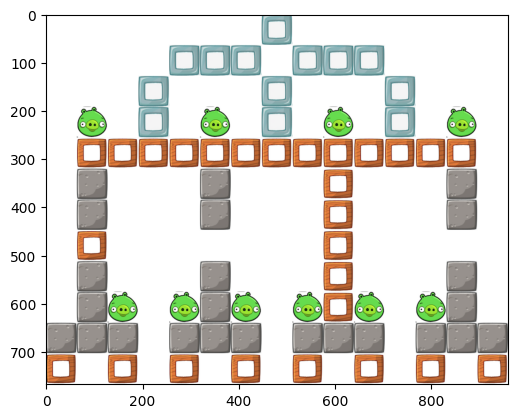

In [418]:
tile_name_to_image = {}
tiles = ["empty", "ice", "stone", "wood", "pig", "tnt"]
for i in range(len(tiles)):
    tile_name_to_image[i] = Image.open(f'angry_birds_tiles/{tiles[i]}.png')
    
tile_dim = tile_name_to_image[0].size

display_level_image(tile_dim, levels[55], tile_name_to_image)

# make network arhcitecture

In [419]:
latent_dim = 8
level_shape = (12,15,1)

# DOWN CONV
encoder_input = tf.keras.Input(shape=level_shape)
conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(encoder_input)
conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same",activation="relu")(conv_1)
conv_3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(conv_2)
flatten = tf.keras.layers.Flatten()(conv_3)

# Mu and Sigma
encoder_output = tf.keras.layers.Dense(256, activation="relu")(flatten)
z_mu = tf.keras.layers.Dense(latent_dim)(encoder_output)
z_log_sigma = tf.keras.layers.Dense(latent_dim)(encoder_output)

# sample re-param trick
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = tf.random.normal(
        shape=(tf.shape(z_mu)[0], latent_dim), mean=0., stddev=1.)
    return z_mu + tf.exp(z_log_sigma) * epsilon
z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mu, z_log_sigma])

# UP CONV
dense_1 = tf.keras.layers.Dense(256, activation="relu")(z)
dense_2 = tf.keras.layers.Dense(np.prod(np.shape(conv_3)[1:]), activation="relu")(dense_1)
reshape = tf.keras.layers.Reshape(np.shape(conv_3)[1:])(dense_2)

conv_4 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3,padding="same",activation="relu")(reshape)
conv_5 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3,padding="same",activation="relu")(conv_4)
conv_6 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, padding="same",activation="relu")(conv_5)

decoder_output = tf.keras.layers.Conv2D(filters=1, kernel_size=3,padding="same",activation="sigmoid")(conv_6)


def vae_loss(x, z_decoded, z_mu, z_log_sigma):
    x = tf.reshape(x[0], (12*15,))
    z_decoded = tf.reshape(z_decoded, (12*15,))
    
    reconstruction_loss = tf.keras.metrics.binary_crossentropy(x, z_decoded) * 12 * 15
 
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_sigma - z_mu**2 - tf.exp(z_log_sigma), axis=-1)
    return reconstruction_loss

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
vae_cnn = tf.keras.Model(encoder_input, [decoder_output, z_mu, z_log_sigma])
vae_cnn.compile(optimizer=optimizer, loss=lambda y_true, y_pred: vae_loss(y_true, y_pred[0], y_pred[1], y_pred[2]))
vae_cnn.summary()

Model: "functional_129"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_113     │ (None, 12, 15, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_351 (Conv2D) │ (None, 12, 15,    │        320 │ input_layer_113[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_352 (Conv2D) │ (None, 12, 15,    │     18,496 │ conv2d_351[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_353 (Conv2D) │ (None, 12, 15,    │     36,928 │ conv2d_352[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_88          │ (None, 11520)     │          0 │ conv2d_353[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_440 (Dense)   │ (None, 256)       │  2,949,376 │ flatten_88[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_441 (Dense)   │ (None, 8)         │      2,056 │ dense_440[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_442 (Dense)   │ (None, 8)         │      2,056 │ dense_440[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_88 (Lambda)  │ (None, 8)         │          0 │ dense_441[0][0],  │
│                     │                   │            │ dense_442[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_443 (Dense)   │ (None, 256)       │      2,304 │ lambda_88[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_444 (Dense)   │ (None, 11520)     │  2,960,640 │ dense_443[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_87          │ (None, 12, 15,    │          0 │ dense_444[0][0]   │
│ (Reshape)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2… │ (None, 12, 15,    │     36,928 │ reshape_87[0][0]  │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2… │ (None, 12, 15,    │     36,928 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2… │ (None, 12, 15,    │     18,464 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_354 (Conv2D) │ (None, 12, 15, 1) │        289 │ conv2d_transpose… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,064,785 (23.14 MB)

 Trainable params: 6,064,785 (23.14 MB)

 Non-trainable params: 0 (0.00 B)

In [420]:
x = levels.reshape((levels.shape[0], levels.shape[1], levels.shape[2], 1))
x_normalized = x / 5
print(x_normalized.shape)

vae_cnn.fit(x=x_normalized, y=x_normalized, epochs=500, batch_size=8)

(60, 12, 15, 1)
Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 120.1920
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 115.7139
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 90.8948
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 90.1907
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 80.8817
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 101.7671
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 96.7631
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 92.7562
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 80.4947
Epoch 10/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 70.3177
Epoch 11/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 94.2367
Epoch 12/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 84.3766
Epoch 13/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 94.6061
Epoch 14/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 85.2444
Epoch 15/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step 

# Generate

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
(12, 15)


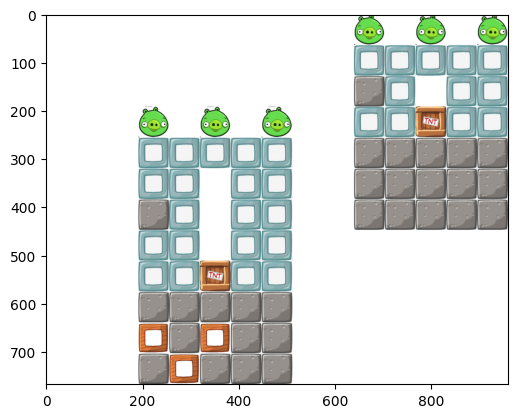

In [421]:
test = x_normalized[5]
gen = vae_cnn.predict(test.reshape(1,12,15,1))[0]
print(gen[0,:,:,0].shape)

display_level_image(tile_dim, np.round(gen[0,:,:,0] * 5), tile_name_to_image)

In [422]:
decoder_input = tf.keras.Input(shape=(latent_dim,))
decoder_layer = vae_cnn.layers[-7](decoder_input)
decoder_layer = vae_cnn.layers[-6](decoder_layer)
decoder_layer = vae_cnn.layers[-5](decoder_layer)
decoder_layer = vae_cnn.layers[-4](decoder_layer)
decoder_layer = vae_cnn.layers[-3](decoder_layer)
decoder_layer = vae_cnn.layers[-2](decoder_layer)
decoder_layer = vae_cnn.layers[-1](decoder_layer)
decoder = tf.keras.Model(decoder_input, decoder_layer)

encoder = tf.keras.Model(encoder_input, z)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
(12, 15, 1)


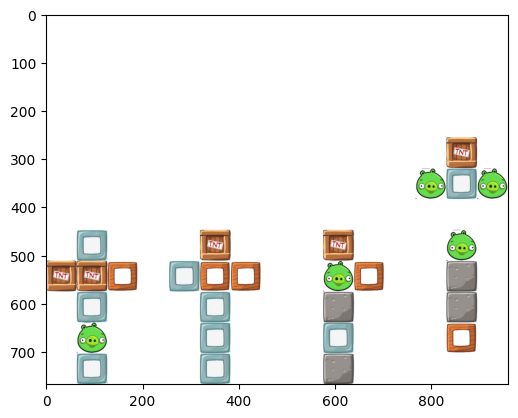

In [428]:
vector_one = encoder.predict(np.array(levels[2]).reshape(1, 12, 15, 1))[0]
vector_two = encoder.predict(np.array(levels[1]).reshape(1, 12, 15, 1))[0]

a = 0.0
vector = vector_one * a + vector_two * (1-a)

gen = decoder.predict(np.array(vector).reshape(1,latent_dim))[0]
print(gen.shape)
display_level_image(tile_dim, np.round(gen[:,:,0] * 5), tile_name_to_image)